In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
#reading the data from the csv file
df = pd.read_csv("C://Users//reddy//Downloads//CPS_3.2_in_Substitute_Care_on_August_31_by_Placement_Type_with_Demographics_FY2014-2023_20240320.csv")  # Make sure to replace 'path_to_your_dataset.csv' with the actual path
print(df.head(5))

   Fiscal Year    County   Region  Gender    Race_Ethnicity  Age  \
0         2023  Anderson  4-Tyler  Female  African American    0   
1         2023  Anderson  4-Tyler  Female  African American    1   
2         2023  Anderson  4-Tyler  Female  African American    7   
3         2023  Anderson  4-Tyler  Female  African American    9   
4         2023  Anderson  4-Tyler  Female  African American   10   

  Type of Substitute Care                Placement Type Relative Placement  \
0             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
1             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
2             Foster Care     DFPS Relative Foster Home           Relative   
3             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
4             Foster Care  CPA Non-Relative Foster Home       Non-Relative   

   Children in Subsitute Care on 31 August  
0                                        1  
1                               

In [3]:
# Categorizing the Age into groups as part of Preprocessing. The categories contain (Infants, young children and Adolescents)
bins = [0, 2, 5, 12, 17, 30]
labels = ['0-2', '3-5', '6-12','13-17','18 and above']

# Create a new column for the age groups
df['Age_Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True, include_lowest=True)
print(df['Age_Category'])

0                  0-2
1                  0-2
2                 6-12
3                 6-12
4                 6-12
              ...     
143337           13-17
143338           13-17
143339           13-17
143340           13-17
143341    18 and above
Name: Age_Category, Length: 143342, dtype: category
Categories (5, object): ['0-2' < '3-5' < '6-12' < '13-17' < '18 and above']


In [8]:
# This function is used to map the Target feature (Placement Type) into different sections. This is done as part of preprocessing for better understanding.
def map_placement_type(row):
    if row in ['CPA Non-Relative Foster Home']:
        return 'CPA_NonRelative'
    elif row in ['CPA Relative Foster Home']:
        return 'CPA_Relative'
    elif row in ['DFPS Non-Relative Foster Home']:
        return 'DFPS_NonRelative'
    elif row in ['CPA Adoptive Home','DFPS Adoptive Home']:
        return 'Adoptive_Home'
    elif row in ['DFPS Relative Foster Home']:
        return 'DFPS_Relative'
    elif row in ['Kinship Care']:
        return 'KinshipCare'
    elif row in ['Residential Treatment Center']:
        return 'RTC'
    else:
        return 'Other'
df['Placement_Type'] = df['Placement Type'].apply(map_placement_type)
df= df[df['Placement_Type'] != 'Other']
print(df['Placement_Type'].head(5))

0    CPA_NonRelative
1    CPA_NonRelative
2      DFPS_Relative
3    CPA_NonRelative
4    CPA_NonRelative
Name: Placement_Type, dtype: object


In [9]:
#Using the Label Encoder so each of the columns can be encoded based on the Type. For example Gender (Male, Female ) will be encoded to (0,1). This is for the convinience of training.
le = LabelEncoder()
df['E_Gender'] = le.fit_transform(df['Gender'])
df['E_Race_Ethnicity'] = le.fit_transform(df['Race_Ethnicity'])
df['E_County'] = le.fit_transform(df['County'])
#df['E_Placement_Type'] = le.fit_transform(df['Placement_Type'])
df['E_Age_Category'] =le.fit_transform(df['Age_Category'] )
#df['County']=le.fit_transform(df['County'])
df['E_Region']=le.fit_transform(df['Region'])
df['E_Type of Substitute Care'] =le.fit_transform(df['Type of Substitute Care'] )
df['E_Relative Placement']=le.fit_transform(df['Relative Placement'])


X = df[['E_Age_Category', 'E_Gender', 'E_Race_Ethnicity','E_County','E_Type of Substitute Care','E_Relative Placement']]  
y = df['Placement_Type']


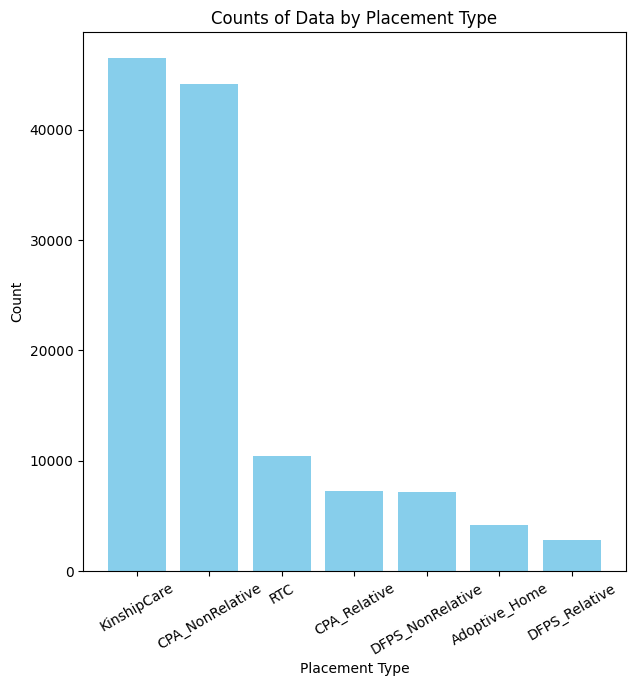

In [10]:
#The figure shows the distribution of classes. Clearly we can see that Unbalanced distribution is present between the classes.
import matplotlib.pyplot as plt 
placement_counts = df['Placement_Type'].value_counts()
placement_counts_filtered = placement_counts
plt.figure(figsize=(7, 7))
plt.bar(placement_counts_filtered.index, placement_counts_filtered.values, color='skyblue')
plt.xlabel('Placement Type')
plt.ylabel('Count')
plt.title('Counts of Data by Placement Type')
plt.xticks(rotation=30)  # Rotate labels to improve readability
plt.show()

Class distribution after resampling: Counter({'Adoptive_Home': 32566, 'CPA_NonRelative': 32566, 'CPA_Relative': 32566, 'DFPS_NonRelative': 32566, 'DFPS_Relative': 32566, 'KinshipCare': 32566, 'RTC': 32566})


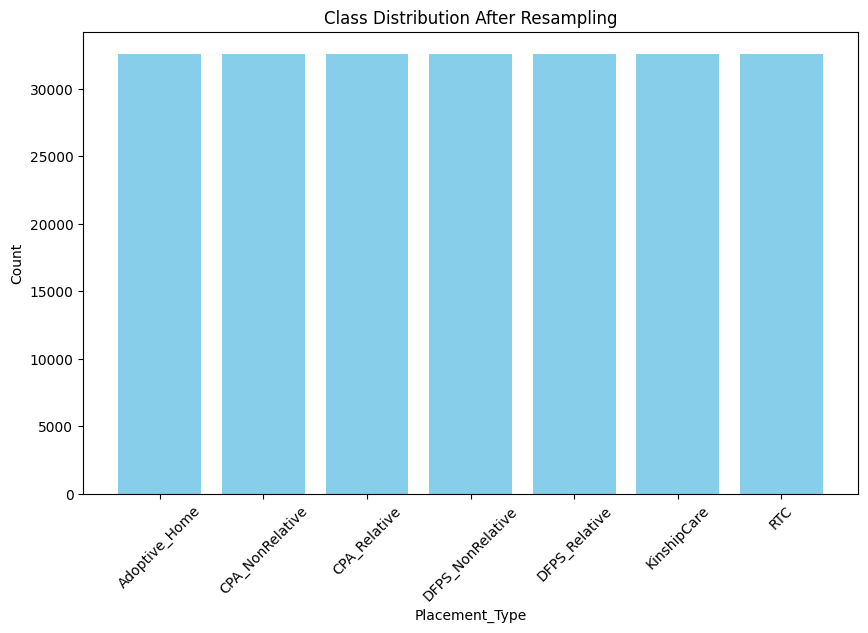

In [19]:
#Apply Combination of SMOTE and undersampling to balance the classes. This works by creating synthetic samples of the minority classes and undersampling works  by removing random majority class instances
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Define RandomUnderSampler model
under_sampler = RandomUnderSampler(random_state=42)

# Create a pipeline that first applies SMOTE then random undersampling
pipeline = Pipeline(steps=[('o', smote), ('u', under_sampler)])

# Apply the pipeline to  data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Count the occurrences of each class in the resampled target variable
class_distribution = Counter(y_resampled)
print("Class distribution after resampling:", class_distribution)
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Placement_Type')
plt.ylabel('Count')
plt.title('Class Distribution After Resampling')
plt.xticks(rotation=45)
plt.show()

In [12]:
#Scaling the data and Applying KNN
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Instantiate the model (using k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train_scaled, y_resampled)
# Predict on the test set
y_pred = knn.predict(X_test_scaled)


In [20]:
#Printing the report
from tabulate import tabulate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:\n{'-'*20}\n{accuracy:.2f}\n{'-'*20}")

# Generate the classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Drop the 'macro avg' and 'weighted avg' rows
report_df = report_df.drop(['accuracy'])

# Optionally, format the DataFrame for a more professional look
# For instance, rounding the numbers and excluding support might be desired
report_df = report_df.round(3)
report_df = report_df[['precision', 'recall', 'f1-score']]  # Exclude 'support' if you want
table = tabulate(report_df, headers='keys', tablefmt='pretty', showindex=True)
print(table)


Accuracy:
--------------------
0.83
--------------------
+------------------+-----------+--------+----------+
|                  | precision | recall | f1-score |
+------------------+-----------+--------+----------+
|  Adoptive_Home   |    1.0    |  1.0   |   1.0    |
| CPA_NonRelative  |   0.724   | 0.955  |  0.824   |
|   CPA_Relative   |   0.744   | 0.927  |  0.826   |
| DFPS_NonRelative |   0.245   | 0.055  |   0.09   |
|  DFPS_Relative   |   0.463   | 0.165  |  0.244   |
|   KinshipCare    |    1.0    |  1.0   |   1.0    |
|       RTC        |   0.509   | 0.096  |  0.161   |
|    macro avg     |   0.669   |  0.6   |  0.592   |
|   weighted avg   |   0.787   | 0.828  |  0.784   |
+------------------+-----------+--------+----------+
